# 결정 트리

## 원리

* 데이터를 가장 잘 구별하는 테스트를 여러번 진행 `특성i 는 값 a보다 큰가?`

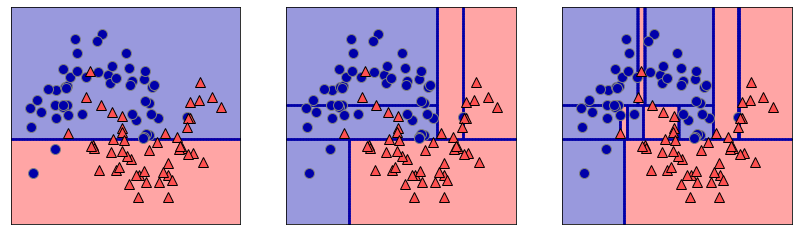

In [1]:
from ml1.preamble import *

from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=3)

mglearn_plot_tree = mglearn.plot_interactive_tree.plot_tree_partition
fig, axes = plt.subplots(1,3, figsize= (14,4))

from sklearn.tree import DecisionTreeClassifier
for max_depth, ax in zip([1,3,9], axes):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(Xm, ym)
    mglearn_plot_tree(Xm,ym,tree,ax=ax)

* tree 만들기는 모든 노드가 순수 노드가 될때까지 할수 있음 => 과대적합
* 이를 막기 위해:
    * 사전 가지치기 : 트리 생성을 일찍 중단
    * 사후 가지치기 : 트리 생성 후 불필요한 노드 삭제/병합
* sklearn에서는 사전 가지치기만 지원

## 코드

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state = 0).fit(X_train,y_train)
print(f'훈련 세트 정확도 : {tree.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {tree.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.937


=> 과대적합, pruning 필요

## Pruning(가지치기)

* max_depth : 최대 깊이 지정

In [3]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_train,y_train)
print(f'훈련 세트 정확도 : {tree.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {tree.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 0.988
테스트 세트 정확도 : 0.951


* min_samples_split : 분할 가능한 노드의 크기 지정

In [4]:
tree = DecisionTreeClassifier(min_samples_split=30, random_state=0).fit(X_train,y_train)
print(f'훈련 세트 정확도 : {tree.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {tree.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 0.977
테스트 세트 정확도 : 0.944


* max_leaf_nodes : 리프의 최대 갯수

In [5]:
tree = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0).fit(X_train,y_train)
print(f'훈련 세트 정확도 : {tree.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {tree.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 0.988
테스트 세트 정확도 : 0.951


## 분석

* 결정 트리 시각화

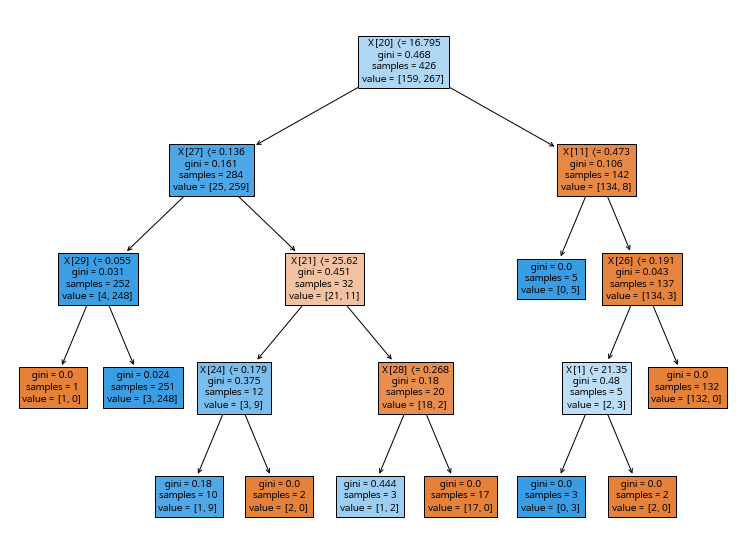

In [6]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(13,10))
plot_tree(tree, filled=True)
plt.show()

* 특성 중요도
    - 0 : 전혀 사용되지 않음
    - 1 : 완벽하게 분류함

In [7]:
tree.feature_importances_

array([0.   , 0.013, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.049, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.729, 0.033, 0.   , 0.   , 0.014, 0.   , 0.018,
       0.122, 0.012, 0.01 ])

(-1.0, 30.0)

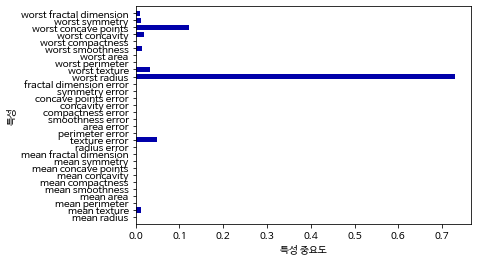

In [8]:
n_features = len(tree.feature_importances_)
plt.barh(np.arange(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel('특성 중요도')
plt.ylabel('특성')
plt.ylim(-1,n_features)

=> 특성 중요도는 항상 양수이므로 어떤 클래스를 지지하는지 알 수 없음<br>
=> 특성 중요도가 낮다고 '유용하지 않다'라고 판단할수 없음(트리가 그 특성을 선택하지 않았을 수도)

## 회귀

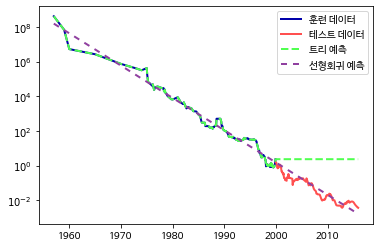

In [9]:
ram_prices = pd.read_csv('ml1/data/ram_price.csv')
data_train, data_test = ram_prices[ram_prices.date<2000], ram_prices[ram_prices.date>=2000]
Xr_train, yr_train = data_train.date.values[:, np.newaxis], np.log(data_train.price)
Xr_all = ram_prices.date.values[:, np.newaxis]
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
tree = DecisionTreeRegressor().fit(Xr_train,yr_train)
linear = LinearRegression().fit(Xr_train,yr_train)
pred_tree, pred_lin = tree.predict(Xr_all), linear.predict(Xr_all)
pred_tree, pred_lin = np.exp(pred_tree), np.exp(pred_lin)
plt.semilogy(data_train.date, data_train.price, label = '훈련 데이터')
plt.semilogy(data_test.date, data_test.price, label = '테스트 데이터')
plt.semilogy(ram_prices.date, pred_tree, label = '트리 예측')
plt.semilogy(ram_prices.date, pred_lin, label = '선형회귀 예측')
plt.yticks(fontfamily='Dejavu Sans')
plt.legend()

=> 트리 모델은 훈련 데이터 밖의 새로운 데이터를 예측할 능력이 없음

## 장단점

### 장점

* 비교적 이해하기 쉬움, 시각화 가능
* 데이터 전처리의 필요성이 적음

### 단점

* 과대적합되는 경향이 있음
* 외삽 불가

# 랜덤 포레스트

## 원리

* 여러개의 트리를 만들어서 그 결과를 평균냄 => 결정 트리의 과대적합을 해결
* 서로 다른 여러개의 트리를 만드는 방법:
    * 데이터 포인트를 무작위로 선택 (부트스트랩)
    * 각 노드에서 사용할 후보 특성을 무작위로 선택<br><br>
* 매개변수:
    * n_estimators : 생성할 트리의 개수
    * max_features : 선택할 특성의 수

## 코드

In [10]:
from sklearn.ensemble import RandomForestClassifier
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, stratify=ym, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(Xm_train,ym_train)
print(f'훈련 세트 정확도 : {forest.score(Xm_train, ym_train):.3f}')
print(f'테스트 세트 정확도 : {forest.score(Xm_test, ym_test):.3f}')

훈련 세트 정확도 : 0.960
테스트 세트 정확도 : 0.920


## 분석

* 결정 경계

Text(0.5, 1.0, '랜덤 포레스트')

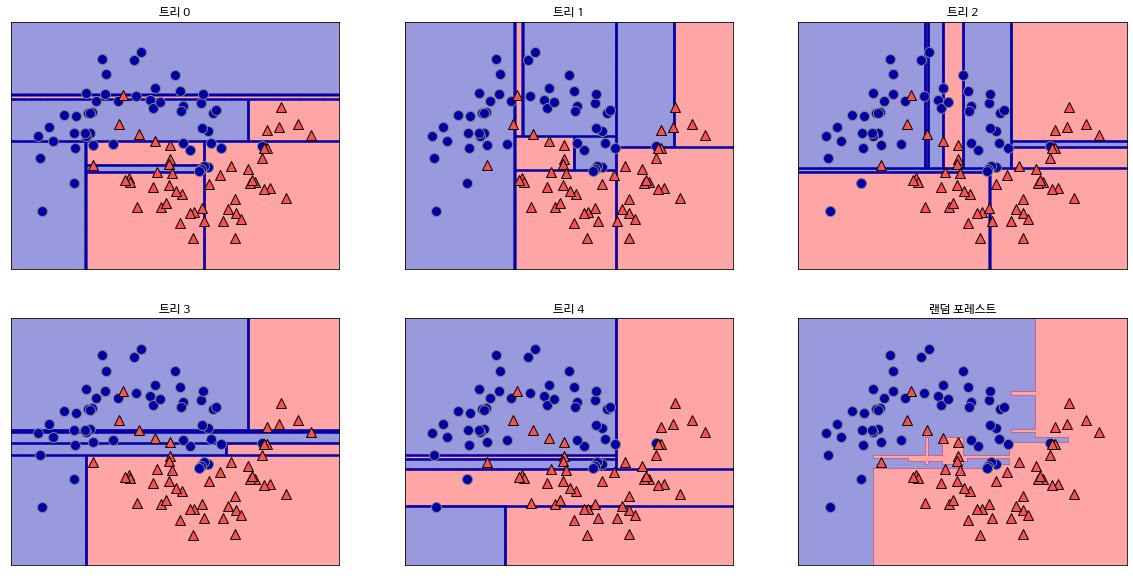

In [11]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title(f'트리 {i}')
    mglearn_plot_tree(Xm, ym, tree, ax=ax)
mglearn.plots.plot_2d_separator(forest, Xm, fill=True, ax=axes[-1,-1], alpha=.4)
mglearn.discrete_scatter(Xm[:,0],Xm[:,1],ym)
axes[-1,-1].set_title("랜덤 포레스트")

=> 각각의 트리는 다르게 생성되고 랜덤포레스트는 덜 과대적합됨<br><br>

* 특성 중요도

(-1.0, 30.0)

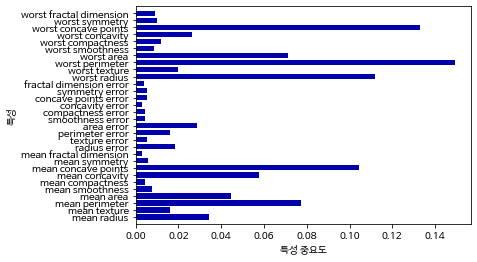

In [12]:
forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

n_features = len(forest.feature_importances_)
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel('특성 중요도')
plt.ylabel('특성')
plt.ylim(-1,n_features)

=> 여러 트리를 취합한 결과이기 때문에 단일 트리보다 신뢰할만함

## 장단점

### 장점

* 성능이 좋음
* 데이터의 스케일을 맞출 필요도 없음

### 단점

* 선형모델보다 시간이 걸릴 수 있음 (n_jobs 컴퓨터 코어 수만큼 향상 가능)
* 텍스트 데이터같이 차원이 높고 희소한 데이터에는 잘 작동 안함

# 그래디언트 부스팅

## 원리

* 랜덤포레스트와는 달리 이전 트리의 오차를 보완하는 방식
* max_depth가 5가 넘어가지 않게
* 매개변수
    * learning_rate : 얼마나 오차를 강하게 보정할 것인지, 클수록 복잡도 증가
    * n_estimators : 추가할 트리의 수, 클수록 복잡도 증가

## 코드

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1).fit(X_train, y_train)
print(f'훈련 세트 정확도 : {gbrt.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {gbrt.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 0.988
테스트 세트 정확도 : 0.958


## 장단점

### 장점

* 매개변수를 잘 설정하면 높은 성능을 가짐
* 랜덤포레스트보다 메모리를 적게 사용하고 예측도 빠름

### 단점

* 매개변수 설정에 더 민감함: 
    * learning_rate를 낮추면 비슷한 복잡도의 모델을 만들기 위해서 n_estimators를 늘려야함
    * n_estimators가 클수록 좋은 랜덤포레스와는 달리 그래디언트부스트는 n_estimators가 크면 과대적합 될 수 있음
    * n_estimators를 강요한 시간과 메모리 한도에서 맞추고 learning_rate를 조절하는 것이 좋음<br><br>
* 훈련시간이 랜덤포레스트보다 김 : 
    * n_iter_no_change로 조기종료 가능
    * xgboost를 설치하면 더 빠르게 할 수 있음

# 엑스트라 트리

## 원리

* 랜덤포레스트와 비슷하지만, 부트스트랩 샘플링을 적용하지 않고 `splitter = 'best'` 대신 `splitter = 'random'` 을 사용함
* 예측 방식은 랜덤포레스트와 동일하게 각 트리가 만든 확률값을 평균시킴

## 코드

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
xtree = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0).fit(X_train, y_train)
print(f'훈련 세트 정확도 : {xtree.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {xtree.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.965


## 분석

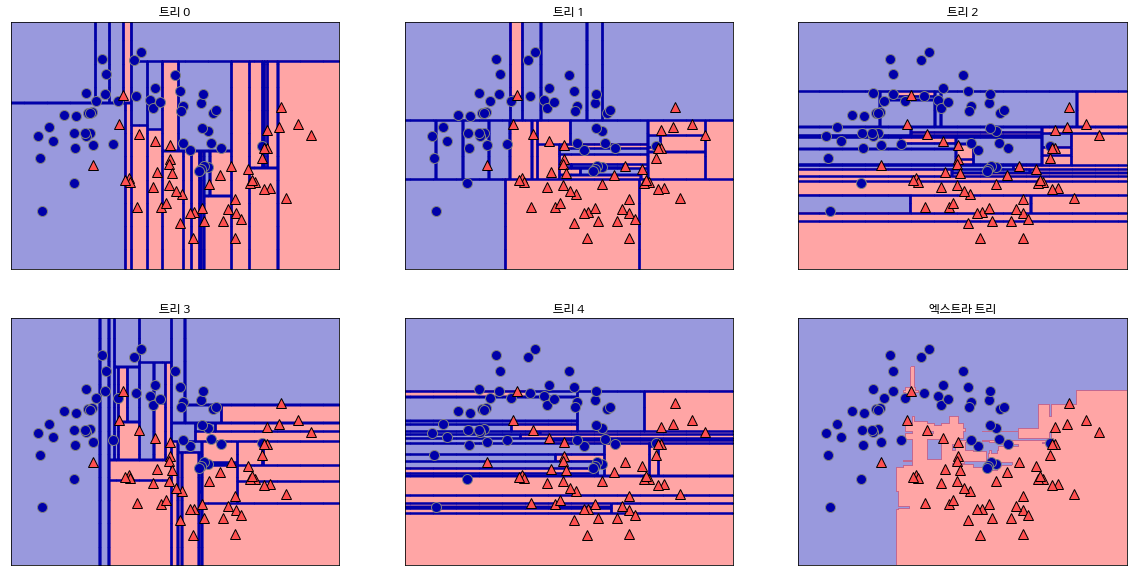

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
xtree = ExtraTreesClassifier(n_estimators=5, n_jobs=2, random_state=0).fit(Xm_train,ym_train)

fig, axes = plt.subplots(2,3, figsize=(20,10))
for i, (ax,tree) in enumerate(zip(axes.ravel(),xtree.estimators_)):
    mglearn_plot_tree(Xm,ym,tree,ax=ax)
    ax.set_title(f'트리 {i}')
mglearn.plots.plot_2d_separator(xtree, Xm, fill=True, ax=axes[-1,-1], alpha=0.4)
mglearn.discrete_scatter(Xm[:,0],Xm[:,1],ym)
axes[-1,-1].set_title('엑스트라 트리')
plt.show()

=> 랜덤포레스트보다 계산 비용이 적지만 일반화 선능을 높이려면 많은 트리를 만들어야 함

# 에이다부스트

## 원리

 * Base_Estimator 생성 (default로 깊이가 1인 결정트리)
 * 얼마나 잘 분류했느냐에 따라 예측비중이 부여됨
 * 이전 모델이 잘못 분류한 샘플에 가중치를 높혀 또 Base_Estimator를 생성
 * 반복후 모든모델의 예측비중를 합산해 예측값 계산

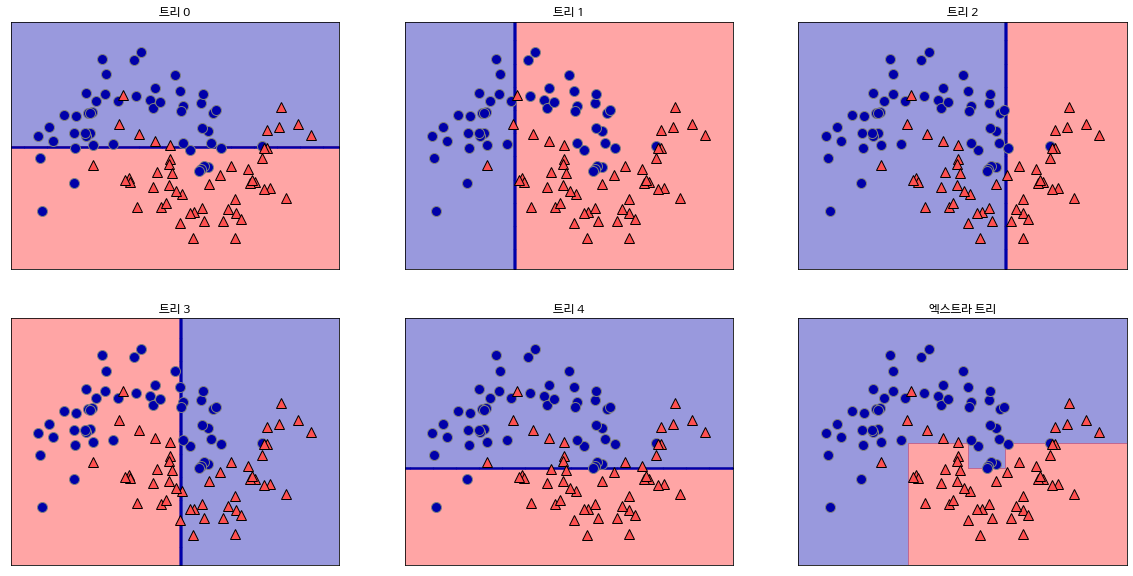

In [16]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=5, random_state=42).fit(Xm_train,ym_train)
fig, axes = plt.subplots(2,3, figsize=(20,10))
for i, (ax,tree) in enumerate(zip(axes.ravel(),ada.estimators_)):
    mglearn_plot_tree(Xm,ym,tree,ax=ax)
    ax.set_title(f'트리 {i}')
mglearn.plots.plot_2d_separator(ada, Xm, fill=True,ax=axes[-1,-1], alpha=0.4)
mglearn.discrete_scatter(Xm[:,0],Xm[:,1],ym)
axes[-1,-1].set_title('엑스트라 트리')
plt.show()

## 코드

In [17]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42).fit(X_train,y_train)
print(f'훈련 세트 정확도 : {ada.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {ada.score(X_test, y_test):.3f}')

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.965


# 배깅

## 원리

* 부트스트랩 샘플을 여러개 만들어 각각에 대해서 모델을 만든후 각 모델의 확률값을 평균하여 예측
* 랜덤 포레스트와 다른점은
    1. 랜덤 포레스트와 달리 max_features 항목이 없음 : 그래서 보통 랜덤포레스트를 씀
    2. 배깅은 tree 모델이 아닌 다른 모델에도 적용 가능

## 코드

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(LogisticRegression(solver='liblinear', max_iter=1000), n_estimators=100,
                           oob_score=True, random_state=42).fit(X_train, y_train)
print(f'훈련 세트 정확도 : {bagging.score(X_train, y_train):.3f}')
print(f'테스트 세트 정확도 : {bagging.score(X_test, y_test):.3f}')

# oob_score는 부트스트랩에 포함되지 않은 샘플을 평가: 테스트 세트의 역할을 대신 할 수 있음 
print(f'OOB 샘플의 정확도 : {bagging.oob_score_:.3f}')

훈련 세트 정확도 : 0.958
테스트 세트 정확도 : 0.951
OOB 샘플의 정확도 : 0.948
